# K-Nearest Neighbor (KNN)

### Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold

import common code (utils)

In [18]:
import sys
from pathlib import Path

# Get current notebook directory
current_dir = Path.cwd()

# Move up until we find 'src'
for parent in current_dir.parents:
    if parent.name == "src":
        sys.path.append(str(parent))
        break
else:
    raise RuntimeError("Could not find 'src' directory")

from common import utils

In [19]:
RANDOM_STATE = 42

### Data Preparation

In [20]:
# Load the CUP training data
ids, X, y = utils.load_cup_data(train=True)

# Split: 90% Development, 10% Internal Test
# We use the same random_state as other group members to ensure consistent splits
X_dev, X_test_internal, y_dev, y_test_internal = utils.split_data(X, y, random_state=RANDOM_STATE)

print(f"Total samples: {len(X)}")
print(f"Development Set shape: {X_dev.shape} (Used for Model Selection)")
print(f"Internal Test Set shape: {X_test_internal.shape} (Used ONLY for final check)")

Total samples: 500
Development Set shape: (450, 12) (Used for Model Selection)
Internal Test Set shape: (50, 12) (Used ONLY for final check)


### Grid search + 5-fold cross-validation
We want to know which KNN configuration (K and weight strategy) gives the lowest validation error?

We do this by:
- Trying many hyperparameter combinations
- Evaluating each one with 5-fold CV
- Measuring error in the original output space
- Storing the average validation MEE

In [21]:
# -------- Define Hyperparameters to study for the grid search

# Number of neighbors K to test (from 1 to 29)
k_values = range(1, 30) 

# Weighting strategies for KNN
# - 'uniform': all neighbors contribute equally (are equally important)
# - 'distance': closer neighbors contribute more (are more important)
weights_strategies = ['uniform', 'distance']

# --------- 5-Fold Cross-Validation

# Create a 5-fold cross-validator
# shuffle=True: randomizes data before splitting
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# here we will store the validation performance for each configuration: K, weight strategy, average validation MEE
results = []

print("Starting Grid Search...")

# Grid search loops
for weight in weights_strategies:
    for k in k_values:

        # This list will store the validation MEE for each fold
        fold_val_mees = []
        # Training MEE for each fold
        fold_train_mees = []
        
        # ----------- CROSS-VALIDATION LOOP

        # Iterate over the 5 folds
        # train_index: indices for training data
        # val_index: indices for validation data
        for train_index, val_index in kf.split(X_dev):
            # 1. SPLIT DATA INTO TRAIN / VALIDATION
            
            # Select training inputs and targets
            X_fold_train = X_dev.iloc[train_index]
            y_fold_train = y_dev.iloc[train_index]

            # Select validation inputs and targets
            X_fold_val = X_dev.iloc[val_index]
            y_fold_val = y_dev.iloc[val_index]
            
            # 2. NORMALIZATION
            
            # Create a scaler object that normalizes both inputs and outputs
            scaler = utils.CupScaler()
            
            # Fit scaler ONLY on training data
            # and transform training inputs and targets
            X_train_scaled, y_train_scaled = scaler.fit_transform(X_fold_train, y_fold_train)
            
            # Transform validation data using the SAME scaler (no fitting here to avoid data leakage)
            X_val_scaled, y_val_scaled = scaler.transform(X_fold_val, y_fold_val)
            
            # 3. TRAIN KNN MODEL

            # Initialize KNN with current hyperparameters
            knn = KNeighborsRegressor(n_neighbors=k, weights=weight)

            # Train KNN on scaled training data
            knn.fit(X_train_scaled, y_train_scaled)
            
            # 4. PREDICT ON VALIDATION SET (Output is Scaled)
            y_pred_scaled = knn.predict(X_val_scaled)
            
            # 5. INVERSE TRANSFORM PREDICTIONS (Back to Original Scale)
            y_pred_original = scaler.inverse_transform_y(y_pred_scaled)
            
            # 6. Compute Error (MEE) in Original Space
            # --- VALIDATION ERROR (VL) ---
            val_mee = utils.mean_euclidean_error(y_true = y_fold_val, y_pred = y_pred_original)
            fold_val_mees.append(val_mee)

            # --- TRAINING ERROR (TR) ---
            # Predict on the Training fold itself
            y_pred_train_scaled = knn.predict(X_train_scaled)
            y_pred_train_original = scaler.inverse_transform_y(y_pred_train_scaled)
            train_mee = utils.mean_euclidean_error(y_fold_train, y_pred_train_original)
            fold_train_mees.append(train_mee)
        
        # Average MEE across folds
        avg_val_mee = np.mean(fold_val_mees)
        avg_train_mee = np.mean(fold_train_mees)
        results.append({
            'k': k, 
            'weight': weight, 
            'val_mee': avg_val_mee,
            'train_mee': avg_train_mee
        })

print("Grid Search Complete.")

# Print results
print("Grid Search Results:")
for result in results:
    print(f"K: {result['k']}, Weights: {result['weight']}, TR MEE: {result['train_mee']:.4f}, VL MEE: {result['val_mee']:.4f}")

Starting Grid Search...
Grid Search Complete.
Grid Search Results:
K: 1, Weights: uniform, TR MEE: 0.0000, VL MEE: 18.0435
K: 2, Weights: uniform, TR MEE: 9.0918, VL MEE: 16.8537
K: 3, Weights: uniform, TR MEE: 10.8899, VL MEE: 16.7126
K: 4, Weights: uniform, TR MEE: 12.3477, VL MEE: 16.9032
K: 5, Weights: uniform, TR MEE: 13.3774, VL MEE: 17.2717
K: 6, Weights: uniform, TR MEE: 14.1247, VL MEE: 17.3921
K: 7, Weights: uniform, TR MEE: 14.7877, VL MEE: 17.6557
K: 8, Weights: uniform, TR MEE: 15.3688, VL MEE: 18.0812
K: 9, Weights: uniform, TR MEE: 15.9648, VL MEE: 18.4398
K: 10, Weights: uniform, TR MEE: 16.5536, VL MEE: 18.8826
K: 11, Weights: uniform, TR MEE: 17.1223, VL MEE: 19.3470
K: 12, Weights: uniform, TR MEE: 17.6195, VL MEE: 19.6334
K: 13, Weights: uniform, TR MEE: 18.0774, VL MEE: 19.9281
K: 14, Weights: uniform, TR MEE: 18.5257, VL MEE: 20.2925
K: 15, Weights: uniform, TR MEE: 18.9216, VL MEE: 20.6306
K: 16, Weights: uniform, TR MEE: 19.2652, VL MEE: 20.9342
K: 17, Weights: 

KNN Model Selection Plot: MEE vs Neighbors (K)

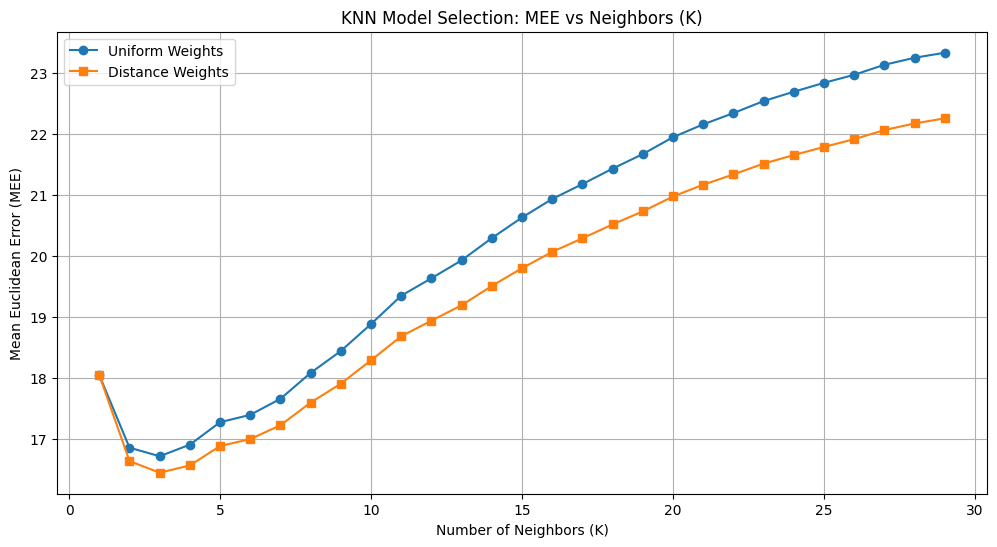

In [22]:
# Convert results to DataFrame for easy plotting
results_df = pd.DataFrame(results)

# Separate data for plotting
uniform_results = results_df[results_df['weight'] == 'uniform']
distance_results = results_df[results_df['weight'] == 'distance']

# Plot MEE vs K
plt.figure(figsize=(12, 6))
plt.plot(uniform_results['k'], uniform_results['val_mee'], marker='o', label='Uniform Weights')
plt.plot(distance_results['k'], distance_results['val_mee'], marker='s', label='Distance Weights')

plt.title('KNN Model Selection: MEE vs Neighbors (K)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Euclidean Error (MEE)')
plt.legend()
plt.grid(True)
plt.show()

### Best Model

Identify the Best Hyperparameters

In [23]:
best_row = results_df.loc[results_df['val_mee'].idxmin()]
best_k = int(best_row['k'])
best_weight = best_row['weight']
best_val_mee = best_row['val_mee']
best_train_mee = best_row['train_mee']

print(f"BEST CONFIGURATION: K={best_k}, Weights={best_weight}")
print(f"Best Validation MEE: {best_val_mee:.4f}")
print(f"Best Training MEE: {best_train_mee:.4f}")

BEST CONFIGURATION: K=3, Weights=distance
Best Validation MEE: 16.4424
Best Training MEE: 0.0000


**Best Model on Internal Test Data:** After selecting the best KNN model using cross-validation, we want to know how well does it perform on unseen data?

Before we test it on the final test data, we want to test it on our internal test data that we separated when we first started. We do this by:

- Retraining the selected model on all development data
- Evaluating once on the internal test set
- Reporting final results

In [24]:
# -----------------------------------------------------
# 1. RETRAIN MODEL ON THE FULL DEVELOPMENT SET
# -----------------------------------------------------

# Create a new scaler object for inputs and outputs (it'll be fitted using ALL development data)
final_scaler = utils.CupScaler()

# Fit the scaler on the entire development set
# and normalize both inputs (X_dev) and outputs (y_dev)
X_dev_scaled, y_dev_scaled = final_scaler.fit_transform(X_dev, y_dev)

# Initialize the final KNN model using the best hyperparameters found via cross-validation
final_knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weight)

# Train the final model on the entire development set
final_knn.fit(X_dev_scaled, y_dev_scaled)

# Compute FINAL TRAINING MEE (TR) on X_dev
y_dev_pred_scaled = final_knn.predict(X_dev_scaled)
y_dev_pred = final_scaler.inverse_transform_y(y_dev_pred_scaled)
final_tr_mee = utils.mean_euclidean_error(y_dev, y_dev_pred)

# -----------------------------------------------------
# 2. EVALUATE MODEL ON THE INTERNAL TEST SET
# -----------------------------------------------------

# Apply the SAME scaler to normalize the test inputs
X_test_scaled, _ = final_scaler.transform(X_test_internal) 

# Use the trained KNN model to predict scaled outputs
y_test_pred_scaled = final_knn.predict(X_test_scaled)

# Convert predicted outputs back to the original scale (de-normalize)
y_test_pred_original = final_scaler.inverse_transform_y(y_test_pred_scaled)

# Compute Mean Euclidean Error (MEE) on the test set (in ORIGINAL scale)
test_mee = utils.mean_euclidean_error(
    y_true=y_test_internal,
    y_pred=y_test_pred_original
)

# -----------------------------------------------------
# 3. FINAL REPORT
# -----------------------------------------------------

print("-" * 30)
print(f"FINAL REPORT (KNN)")
print("-" * 30)
print(f"Selected Hyperparameters: K={best_k}, Weights={best_weight}")
print(f"{'MEE Training (TR)':<20} | {final_tr_mee:.4f}")
print(f"{'MEE Validation (VL)':<20} | {best_val_mee:.4f}")
print(f"{'MEE Internal Test (TS)':<20} | {test_mee:.4f}")
print("-" * 30)

------------------------------
FINAL REPORT (KNN)
------------------------------
Selected Hyperparameters: K=3, Weights=distance
MEE Training (TR)    | 0.0000
MEE Validation (VL)  | 16.4424
MEE Internal Test (TS) | 15.1285
------------------------------


**PLOTTING THE "LEARNING CURVE" (Complexity Curve for KNN)**

We were asked for TR vs VL. For our KNN, this means plotting Error vs K. We used only the BEST weight strategy to make the plot readable.

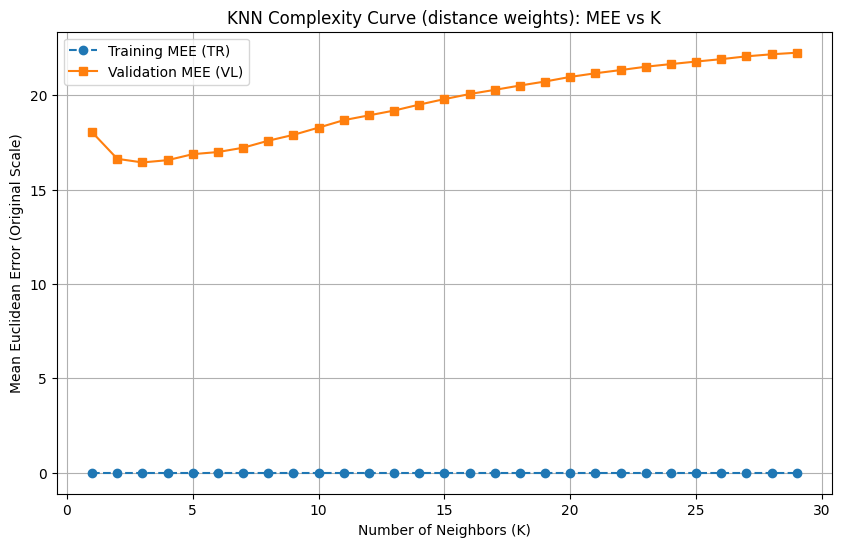

In [25]:
subset = results_df[results_df['weight'] == best_weight]

plt.figure(figsize=(10, 6))
plt.plot(subset['k'], subset['train_mee'], label='Training MEE (TR)', marker='o', linestyle='--')
plt.plot(subset['k'], subset['val_mee'], label='Validation MEE (VL)', marker='s')

plt.title(f'KNN Complexity Curve ({best_weight} weights): MEE vs K')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Euclidean Error (Original Scale)')
plt.legend()
plt.grid(True)
plt.show()

### Generate Blind Test Predictions

We must apply the final model to the 1000 patterns in ML-CUP25-TS.csv. We will create a file named SYC_ML-CUP25-TS.csv.Structure: It must be a comma-separated file with the ID in the first column followed by the 4 predicted targets ($t1, t2, t3, t4$). No header, no comments.

In [26]:
# SYC = Salmi Yakoubi Chafai
TEAM_NAME = "SYC" 

print("Generating Blind Test predictions...")

# 1. Load the Blind Test Data (ML-CUP25-TS.csv)
# We use pandas directly here to handle the file structure
try:
    blind_ids, blind_X, _ = utils.load_cup_data(train=False)
    
    print(f"Loaded {len(blind_ids)} blind test samples.")

    # 2. Normalize the Blind Inputs
    # CRITICAL: Use the SAME final_scaler fitted on the Dev Set
    # We pass y_test=None because we don't have targets here
    blind_X_scaled, _ = final_scaler.transform(blind_X)

    # 3. Predict using the Final Model
    blind_y_pred_scaled = final_knn.predict(blind_X_scaled)

    # 4. Inverse Transform (De-normalize) to Original Scale
    # We must report results in the original 4D target space
    blind_y_pred_original = final_scaler.inverse_transform_y(blind_y_pred_scaled)

    # 5. format the Output
    # The requirement is: ID, pred1, pred2, pred3, pred4
    # Create a DataFrame for easy CSV export
    output_df = pd.DataFrame(blind_y_pred_original)
    
    # Insert the ID column at the beginning (index 0)
    output_df.insert(0, 'ID', blind_ids)

    # 6. Save to CSV
    output_filename = f"{TEAM_NAME}_ML-CUP25-TS.csv"
    
    # header=False, index=False is MANDATORY based on prof's rules
    output_df.to_csv(output_filename, header=False, index=False)

    print(f"SUCCESS: Predictions saved to {output_filename}")

except Exception as e:
    print(f"ERROR: Could not process blind test file. Reason: {e}")

Generating Blind Test predictions...
Loaded 1000 blind test samples.
SUCCESS: Predictions saved to SYC_ML-CUP25-TS.csv
